In [1]:
from herbie import Herbie
from herbie import FastHerbie
import pandas as pd
import pickle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from paint.standard2 import cm_tmp, cm_wind, cm_wave_height, cm_pcp
from toolbox import EasyMap, pc, ccrs
import xarray as xr
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import pvlib

import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature

Let's load our earlier profiles:
- day-ahead forecasted power based on the coarsened HRRR
- forecasted power based on max and min from the coarsened HRRR
- normalized "max-min" range
- weighted average TCC from GEFS
- modeled actual power (from HRRR)
- modeled clear sky power

In [2]:
p_ac_hrrr_coarse_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_all.pkl')
p_ac_hrrr_coarse_max_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_max_all.pkl')
p_ac_hrrr_coarse_min_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_min_all.pkl')
max_min_norm = pd.read_pickle('example_data/max_min_norm_20210408.pkl')
weighted_avg_tcc = pd.read_pickle('example_data/weighted_avg_tcc_20210408.pkl')

power_ac_cs_all = pd.read_pickle('example_data/power_ac_cs_all.pkl')
p_ac_hrrr_actuals_all = pd.read_pickle('example_data/p_ac_hrrr_actuals_all.pkl')

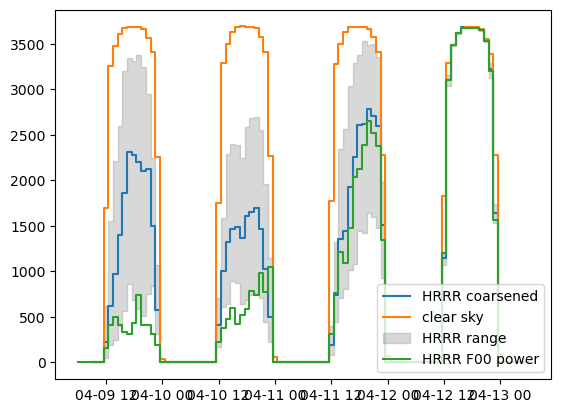

In [31]:
mask = (power_ac_cs_all.index >= p_ac_hrrr_coarse_all.index[0]) & (power_ac_cs_all.index <= p_ac_hrrr_coarse_all.index[-1])

plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR coarsened')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power')
plt.legend(loc='lower right')
plt.show()

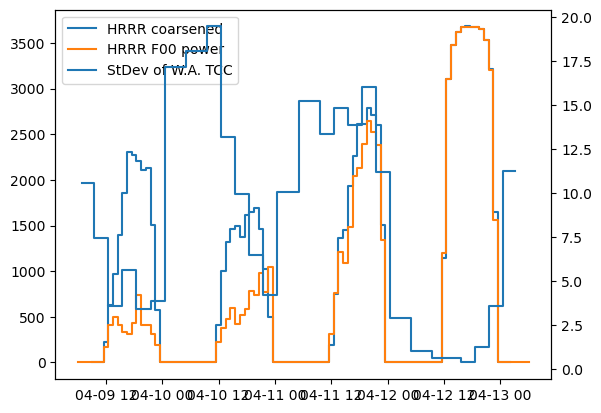

In [11]:
mask = (power_ac_cs_all.index >= p_ac_hrrr_coarse_all.index[0]) & (power_ac_cs_all.index <= p_ac_hrrr_coarse_all.index[-1])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR coarsened')

lns2 = ax1.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power')

lns3 = ax2.plot(weighted_avg_tcc.index, weighted_avg_tcc.tcc_std, drawstyle='steps-mid',
         label='StDev of W.A. TCC')

# Solution for having two legends
leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)

plt.show()

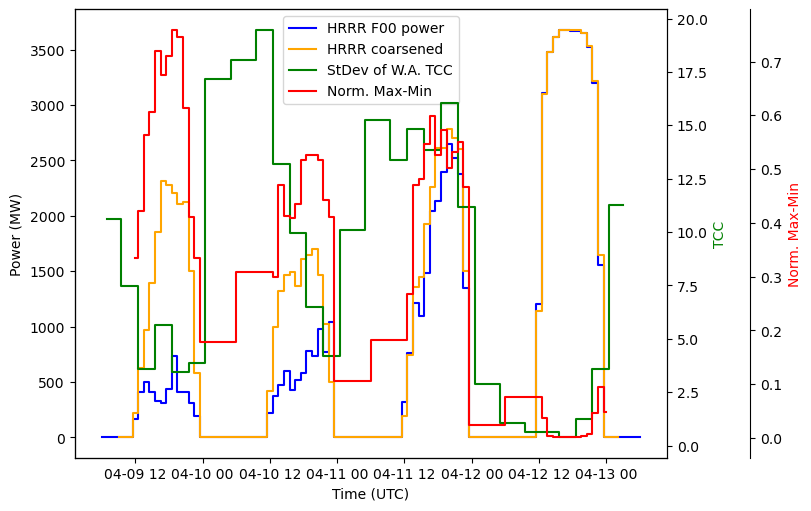

In [27]:
# More versatile wrapper
fig, ax1 = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches

ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# ax2.set_ylim(0, 4)
# ax3.set_ylim(1, 65)
    
ax1.set_xlabel("Time (UTC)")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("TCC")
ax3.set_ylabel("Norm. Max-Min")

color1, color2, color3 = plt.cm.viridis([0, .5, .9])

p1 = ax1.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power',
         color='blue',
         )

p2 = ax1.plot(p_ac_hrrr_coarse_all.index,
              p_ac_hrrr_coarse_all.power_ac,
              drawstyle='steps-mid',
              label='HRRR coarsened',
              color='orange',
              )

p3 = ax2.plot(weighted_avg_tcc.index, weighted_avg_tcc.tcc_std, drawstyle='steps-mid',
         label='StDev of W.A. TCC', color='green')

p4 = ax3.plot(max_min_norm.index, max_min_norm.max_min_norm, drawstyle='steps-mid',
         label='Norm. Max-Min', color='red')

ax1.legend(handles=p1+p2+p3+p4, loc='upper center')

# right, left, top, bottom
ax3.spines['right'].set_position(('outward', 60))

# ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p3[0].get_color())
ax3.yaxis.label.set_color(p4[0].get_color())